In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bandit import Bandits_final

In [2]:
np.random.seed(0)

In [3]:
def decaying_epsilon_greedy(mab, num_steps=5000, epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=0.001, alpha=-1):
    k = mab.k  # number of actions
    Q = np.zeros(k)  # estimated values for each action
    N = np.zeros(k)  # number of times each action was taken

    rewards = []
    optimal_action_counts = np.zeros(num_steps)
    cumulative_regret = np.zeros(num_steps)

    epsilon = epsilon_start
    total_regret = 0

    for t in range(num_steps):
        if np.random.rand() < epsilon:
            action = np.random.randint(0, k)  # exploration
        else:
            action = np.argmax(Q)  # exploitation

        _, reward, _, _, _ = mab.step(action)

        rewards.append(reward)

        # check if the action was optimal
        optimal_action = mab.get_optimal_action()
        if action == optimal_action:
            optimal_action_counts[t] = 1  # mark as optimal

        # update cumulative regret
        regret = mab.means[optimal_action] - reward
        total_regret += regret
        cumulative_regret[t] = total_regret

        N[action] += 1
        # if alpha is -1, the step size is dynamic, averaging the rewards;
        # with constant alpha, each reward has equal weight, with increased response to recent rewards.
        step_size = 1 / N[action] if alpha == -1 else alpha
        Q[action] += step_size * (reward - Q[action])

        epsilon = max(epsilon_min, epsilon_decay * epsilon)

    percent_optimal_actions = np.cumsum(optimal_action_counts) / np.arange(1, num_steps + 1)

    return rewards, percent_optimal_actions, cumulative_regret

In [4]:
def run_bandit_simulation(strategy_func, num_runs=500, num_steps=5000, **strategy_kwargs):
    avg_reward = np.zeros(num_steps)
    avg_optimal_actions = np.zeros(num_steps)
    avg_cumulative_regret = np.zeros(num_steps)

    for run in range(num_runs):
        mab = Bandits_final()
        rewards, percent_optimal_actions, cumulative_regret = strategy_func(mab, num_steps=num_steps, **strategy_kwargs)
        avg_reward += rewards
        avg_optimal_actions += percent_optimal_actions
        avg_cumulative_regret += cumulative_regret

    avg_reward /= num_runs
    avg_optimal_actions /= num_runs
    avg_cumulative_regret /= num_runs
    return avg_reward, avg_optimal_actions, avg_cumulative_regret

In [5]:
step_sizes = [-1, 0.01, 0.1, 0.25]
dec_eps_greedy_simulation_results = [run_bandit_simulation(strategy_func=decaying_epsilon_greedy, alpha=step_size) for
                                     step_size in step_sizes]

In [16]:
def plot_simulation_results(simulation_results, labels):
    cmap = plt.get_cmap("tab20b")
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, (avg_reward, percent_optimal_actions, cumulative_regret) in enumerate(simulation_results):
        label = labels[i]
        axs[0].plot(avg_reward, label=label, color=cmap(i / len(simulation_results)))
        axs[1].plot(percent_optimal_actions, label=label, color=cmap(i / len(simulation_results)))
        axs[2].plot(cumulative_regret, label=label, color=cmap(i / len(simulation_results)))

    axs[0].set_title("Average Reward")
    axs[0].set_ylabel("Average Reward")
    axs[1].set_title("Percentage of Optimal Actions")
    axs[1].set_ylabel("Optimal Action %")
    axs[2].set_title("Cumulative Regret")
    axs[2].set_ylabel("Cumulative Regret")

    for i in range(3):
        axs[i].set_xlabel("Steps")
        axs[i].grid(color='silver', linestyle="--", linewidth=0.5)
    
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=len(labels))

    plt.tight_layout()
    plt.show()

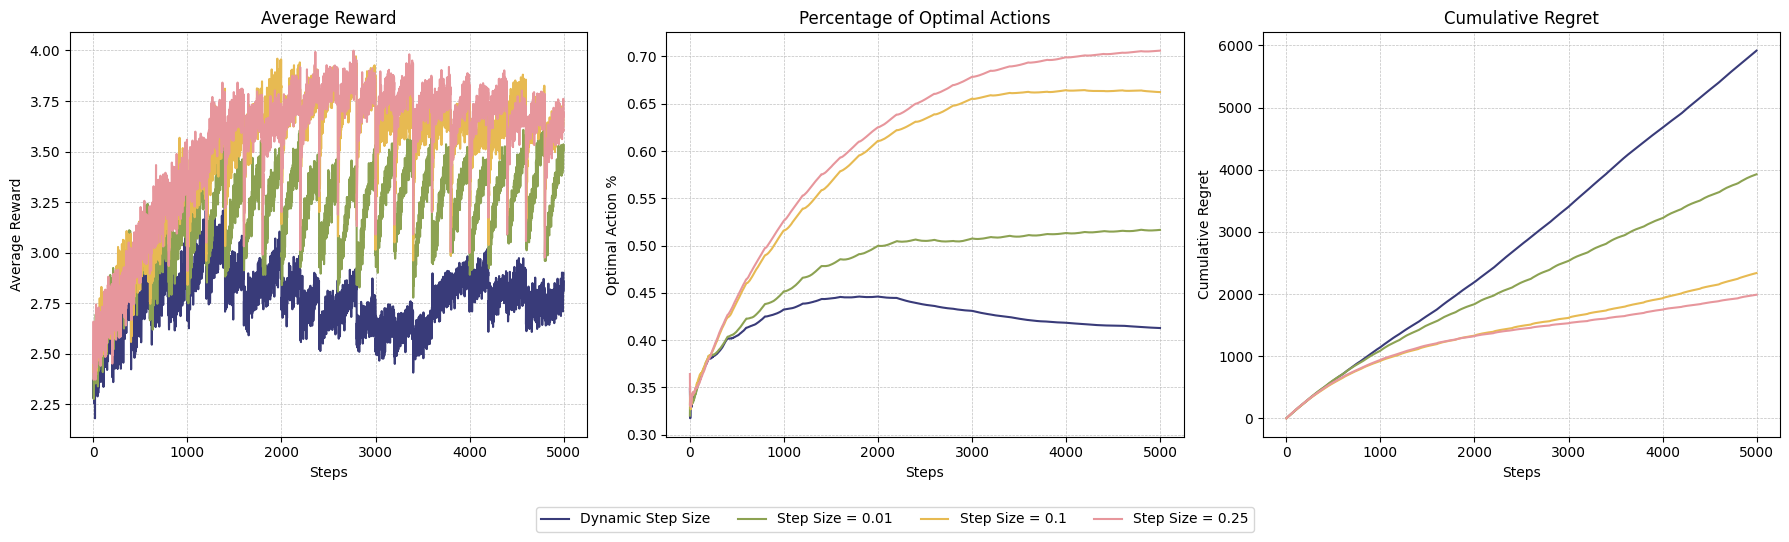

In [17]:
dec_eps_greedy_simulation_labels = ["Dynamic Step Size" if alpha == -1 else f"Step Size = {alpha}" for alpha in
                                    step_sizes]
plot_simulation_results(dec_eps_greedy_simulation_results, dec_eps_greedy_simulation_labels)